In [1]:
!pip install mne
!pip install EDFlib-Python
!pip install autoreject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd 
import mne
from autoreject import AutoReject, get_rejection_threshold

In [3]:
data = pd.read_csv('B.txt', delimiter = ",", header = None)
print(data.shape)

data = data.iloc[:, 1:9]

(149746, 25)


In [4]:
#data = pd.read_csv('A.csv', delimiter = "\t", header = None)# .iloc[:,1:9]

print(data.shape)
data.head()

(149746, 8)


,1,2,3,4,5,6,7,8
0,4125.416771,20708.310092,198.863470,-2136.670308,2.783188e+06,7469.729480,2.781326e+06,-187500.022352
1,4120.789960,20711.886372,196.494186,-2142.749982,2.783104e+06,7455.849046,2.781387e+06,-187500.022352
2,4081.562648,20705.449069,186.949991,-2149.053174,2.782839e+06,7487.856744,2.783676e+06,-187500.022352
3,4088.804613,20700.039947,192.850851,-2142.370003,2.782607e+06,7506.274582,2.785442e+06,-187500.022352
4,4103.713227,20700.643444,195.331895,-2141.230064,2.782491e+06,7488.594352,2.785924e+06,-187500.022352


In [5]:
ch_names = ['Fp1', 'Fp2', 'C1', 'C2', 'P7', 'P8', 'O1', 'O2']

sfreq = 250 
info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
info['experimenter'] = 'Michael Huang, Adan Montes de Oca, Sripad Karne'

raw = mne.io.RawArray(data.transpose(), info)
raw

Creating RawArray with float64 data, n_channels=8, n_times=149746
    Range : 0 ... 149745 =      0.000 ...   598.980 secs
Ready.


<RawArray | 8 x 149746 (599.0 s), ~9.2 MB, data loaded>

In [6]:
onset_li = [0, 52.28, 67.28, 121.78, 136.78, 168.14, 183.14, 210.50, 225.50, 249.94, 264.94, 297.32, 312.32, 329.55, 344.55 ,406.04, 421.04, 450.62, 465.62, 483.01, 498.01, 553.49, 568.49]
duration_li = [round(j - i,2) for i, j in zip(onset_li[:-1], onset_li[1:])] + [600 - onset_li[-1]]

description_labels = [1,0] # 1 = Meditation, 0 = Questions
description_li = description_labels*11 + [1]

med_annotations = mne.Annotations(onset= onset_li,  # in seconds
                           duration= duration_li,  # in seconds, too
                           description= description_li)
print(med_annotations)

raw.set_annotations(med_annotations)

<Annotations | 23 segments: 0 (11), 1 (12)>


<ipython-input-6-ac3f8df766da>:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(med_annotations)


<RawArray | 8 x 149746 (599.0 s), ~9.2 MB, data loaded>

In [7]:
raw.annotations.save('meditation-annotations.txt', overwrite=True)
#pd.read_csv('meditation-annotations.txt')



Overwriting existing file.


Using matplotlib as 2D backend.


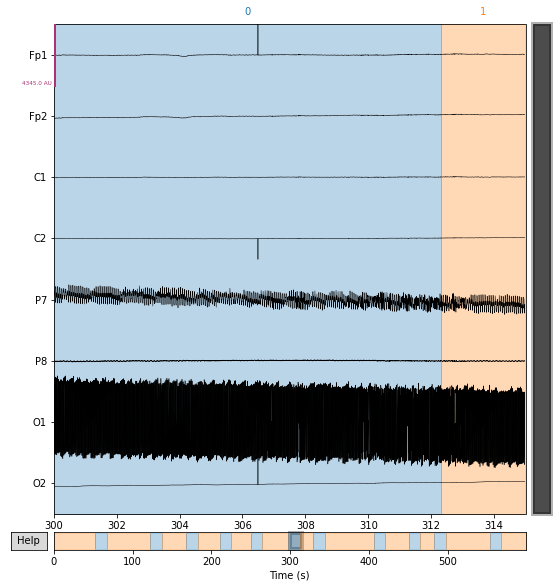

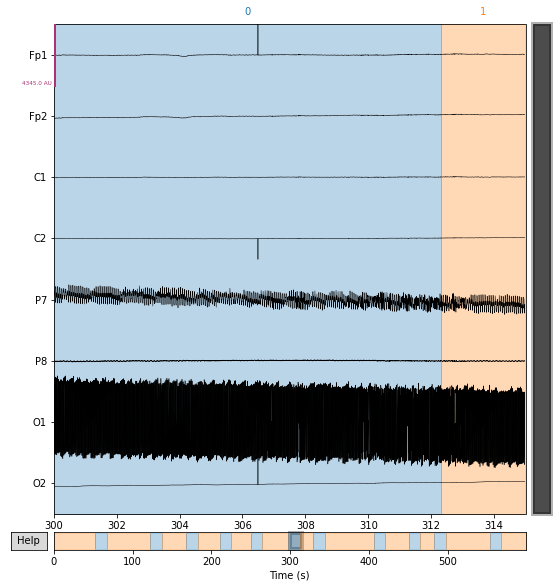

In [8]:
raw.plot(duration = 15, start=300)

In [9]:
mne.export.export_raw('meditation.edf',raw, fmt='edf', overwrite = True)

Overwriting existing file.


<ipython-input-9-6b87a449d098>:1: RuntimeWarning: EDF format requires equal-length data blocks, so 0.016 seconds of zeros were appended to all channels when writing the final block.
  mne.export.export_raw('meditation.edf',raw, fmt='edf', overwrite = True)


# CSP Classifier

In [10]:
# Reminder: use this code in the for loop in place of epochs.drop_bad()
# ar = AutoReject()
#epochs_clean = ar.fit_transform(epochs)  

# Ignore what I said about deleting the raw_filter part of the code in the for loop. You'll need it